In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from utils import draw_mols_with_highlight

# Helper functions

In [3]:
def plot_fragments_within_cpd_groups(df, path, frag_smi_col = 'fragment_SMILES', cpd_smi_col = 'SMILES', name_col = '', file_name_col = ''):
    for frag, smalldf in df.groupby(frag_smi_col):
        mols = [Chem.MolFromSmiles(smi) for smi in smalldf[cpd_smi_col]]
        legends = ''
        if name_col != '':
            legends = list(smalldf[name_col])
            
        name = frag
        if file_name_col !='':
            name = list(smalldf[file_name_col])[0]
        draw_mols_with_highlight(mols, frag, legends=legends, file_path=path + name + '.png')

In [3]:
def preprocess_df_sort_according_to_hit(df, hit_col_dict={}, rd_col_name = 'Round', frag_smi_col = 'fragment_SMILES', cpd_smi_col = 'SMILES', frag_prefix = 'SF'):
    
    # get the hit rates for each fragment
    fixed_df = pd.DataFrame()
    for rd_col in hit_col_dict.keys():
        smalldf = df[df[rd_col_name] == rd_col]
        smalldf['HIT'] = list(smalldf[hit_col_dict[rd_col]])
        fixed_df = pd.concat([fixed_df,smalldf])
    df = fixed_df.copy()
    hit_rates = []
    frags = []
    total_nums = []
    for frag, smalldf in df.groupby(frag_smi_col):
        hits = [1.0 if x==True else 0.0 for x in list(smalldf['HIT'])]
        hit_rate = sum(hits) / len(hits)
        frags.append(frag)
        hit_rates.append(hit_rate)
        total_nums.append(sum(hits))
        
    # sort original df based on hit rate
    frag_hit_dict = dict(zip(frags, hit_rates))
    frag_num_dict = dict(zip(frags, total_nums))
    df['hit_rate'] = [frag_hit_dict[frag] for frag in list(df[frag_smi_col])]
    df['number_of_cpds_for_frag'] = [frag_num_dict[frag] for frag in list(df[frag_smi_col])]
    df = df.sort_values(by = ['hit_rate', frag_smi_col], ascending = False)
    df = df.reset_index(drop = True)
    
    # name fragments based on Fx (x is 1 thru N sorted based on descending hit rate)
    sorted_indices = sorted(range(len(hit_rates)), key=lambda k: (hit_rates[k],frags[k]), reverse = True)
    frags = [frags[i] for i in sorted_indices]
    frag_name_dict = dict(zip(frags, [frag_prefix + str(i+1) for i in range(len(frags))]))
    df['fragment_name'] = [frag_name_dict[frag] for frag in list(df[frag_smi_col])]
    
    # finally, return df so df is ONLY hits
    hits = df[[x==1.0 for x in list(df['HIT'])]]
    nonhits = df[[x==0.0 for x in list(df['HIT'])]]

    return(hits,nonhits)

def plot_fragment_hit_rates(df, path, threshold_above_1 = True, fig_size = (3.5, 3), num_col = 'number_of_cpds_for_frag', hit_rate_col = 'hit_rate', frag_name_col = 'fragment_name'):

    # plot fragments hit rates
    fig, ax = plt.subplots(figsize = fig_size, dpi = 300)

    if threshold_above_1:
        df = df[df['number_of_cpds_for_frag'] > 1]
    xs = [int(x) for x in list(df[num_col])]
    ys = list(df[hit_rate_col])
    labs = df[frag_name_col]
    plt.bar(x=labs, height=ys)

    rects = ax.patches
    for rect, label in zip(rects, xs):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, ' ' + str(label), fontsize = 8, rotation = 90, ha="center", va="bottom"
        )

    plt.xticks(fontsize = 8, rotation = 90)
    plt.yticks(fontsize = 8, rotation = 90)
    plt.ylabel('Hit Rate for Fragment')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(path + '.png')
    plt.savefig(path + '.svg')
    plt.show()

# Plot top antibiotics from Stokes et al. 2020

In [23]:
table2b = pd.read_excel('../data/static_datasets/Stokes_et_al_2020_TableS2.xlsx', sheet_name = 'S2B', header = 1)
top_cpds = table2b[table2b['Mean_Inhibition'] < 0.2]
top_cpds = top_cpds.reset_index(drop=True)
top_cpds = table2b.iloc[0:5,:]
top_cpd_smis = top_cpds['SMILES']
top_cpd_names = list(top_cpds['Name'])
mols = [Chem.MolFromSmiles(smi) for smi in top_cpd_smis]

quinolone = 'O=c1cc[nH]c2ccccc12'
betalactam = 'O=C1CCN1'

path = '../figure_panels/stokes_et_al_predicted_quinolone.png'
q_idx = [1,4]
draw_mols_with_highlight([mols[i] for i in q_idx], quinolone, legends=[top_cpd_names[i] for i in q_idx], file_path=path)

path = '../figure_panels/stokes_et_al_predicted_lactam.png'
b_idx = [0,2,3]
draw_mols_with_highlight([mols[i] for i in b_idx], betalactam, legends=[top_cpd_names[i] for i in b_idx], file_path=path)

# Round1 Pilot

In [5]:
fulldf = pd.read_csv('../data/experimental_validation/combined_cpd_and_frag_results_up_through_round5_sa.csv')
rd1 = fulldf[fulldf['Round'] == 'Round1-Pilot']
rd1 = rd1[rd1['Confirmed-Hit'] == True]
path = '../figure_panels/fragments/pilot-rd1/'
plot_fragments_within_cpd_groups(rd1, path = path)

# Rounds 1 - 6 for SA frags

In [6]:
rd6 = pd.read_csv('../data/experimental_validation/round6_cleaned_results.csv')
fulldf = pd.concat([fulldf, rd6])

hit_col_dict = {'Round1-Pilot':'Confirmed-Hit', 
                'Round2-17atom':'Hit-OD',
               'Round3-Enamine': 'Confirmed-Hit',
               'Round4-Enamine Fragments+Broad': 'Hit-OD',
               'Round5-GDB11,17+Broad':'Hit-OD',
               'Round6-Enamine_frags_no_cpd': 'Confirmed-Hit'}

hits1thru6, nonhits1thru6 = preprocess_df_sort_according_to_hit(fulldf, hit_col_dict)
path = '../figure_panels/fragments/sard1thru6/'
plot_fragments_within_cpd_groups(hits1thru6, name_col = 'Name', file_name_col = 'fragment_name', path = path)
plot_fragments_within_cpd_groups(nonhits1thru6, name_col = 'Name', file_name_col = 'fragment_name', path = path + 'nonhit_')


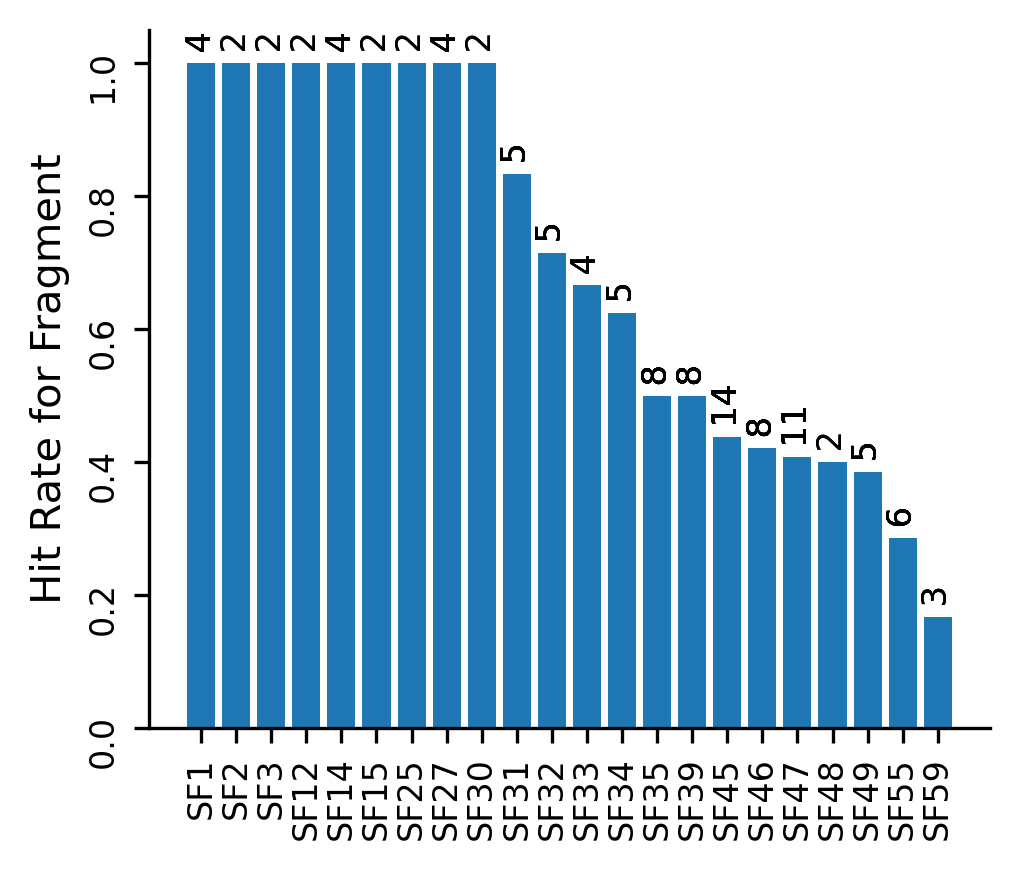

In [7]:
plot_fragment_hit_rates(hits1thru6, '../figure_panels/successful_sa_frags')

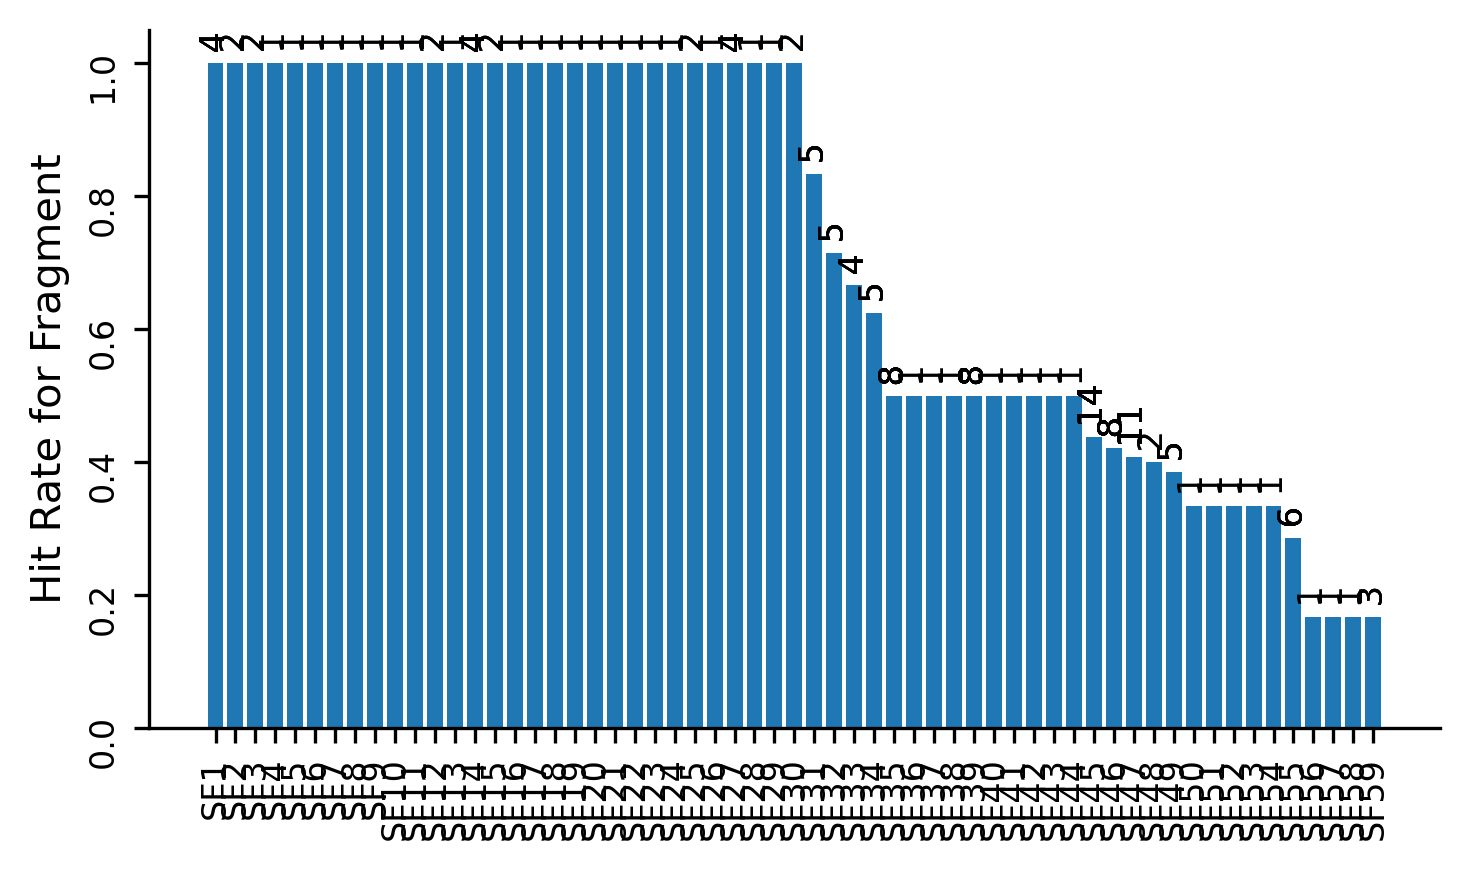

In [8]:
plot_fragment_hit_rates(hits1thru6, '../figure_panels/successful_sa_frags_all', threshold_above_1 = False, fig_size = (5, 3))

# Round 1 for NG frags

In [9]:
rd1ng = pd.read_csv('../data/experimental_validation/ng_rd1_experimental.csv')
hit_col_dict = {'Round1-NG':'hit'}

hits, nonhits = preprocess_df_sort_according_to_hit(rd1ng, hit_col_dict, frag_prefix = 'NF')
path = '../figure_panels/fragments/ngrd1/'
plot_fragments_within_cpd_groups(hits, name_col = 'Name', file_name_col = 'fragment_name', path = path)
plot_fragments_within_cpd_groups(nonhits, name_col = 'Name', file_name_col = 'fragment_name', path = path + 'nonhit_')

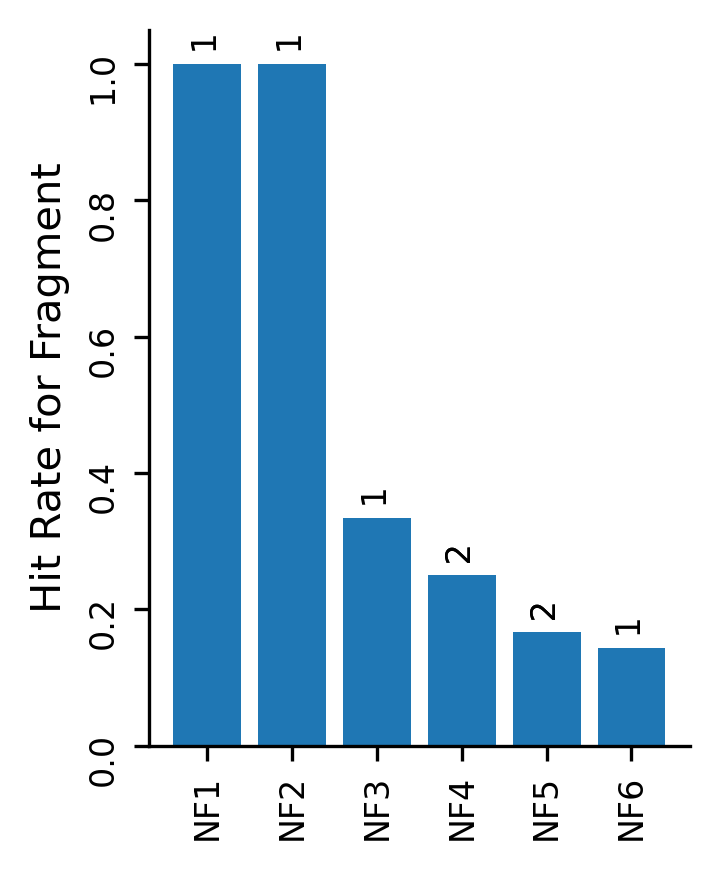

In [10]:
plot_fragment_hit_rates(hits, '../figure_panels/successful_ng_frags', fig_size = (2.5,3), threshold_above_1 = False)

# V027 De Novo Design Cpds - SA

In [5]:
v027_df = pd.DataFrame()
v027_df['Compound'] = ['C1', 'C2', 'C3']
v027_df['SMILES'] = ['O=C(c1ccc(SC(c(c[nH]2)c3c2ccc(Cl)c3)c4c(Cl)cc(Cl)cc4)cc1)O', 'O=C(c1ccc(OC(c(c[nH]2)c3c2ccc(Cl)c3)c4ccc(Cl)cc4)cc1)O', 'O=C(c1ccc(SC(c(c[nH]2)c3c2ccc(Cl)c3)c4c(Br)cc(Cl)cc4)cc1)O']
v027_df['fragment_SMILES'] = ['C(C1=CNC2=C1C=CC=C2)C1=CC=CC=C1'] * 3

path = '../figure_panels/fragments/denovo/'
plot_fragments_within_cpd_groups(v027_df, path = path, name_col = 'Compound')